# Intrusion Detection on the KDD Cup 99 Data Set
*A relative comparison of models for the classification of network data and methodologies for their evaluation.*

--- 


The KDD Cup 99 data set [3], being one of the few publically available data sets of this size and nature, has receieved a large amount of study and analysis within academic community. This has provided a pool of prior work to learn from.

In particular, Katos 2007 [15] evaluated three key approaches to detecting normal and malicious connections within the KDD 99 data set  - cluster, discriminant and logit analysis. Their results found that logistic regression was the most effective method out of those investigated. For this reason, we have chosen to compare variants of logistic regression with a model not explored in that paper: support vector machines. 
    
We have allocated the work as follows:
  1. Shanglin will work on the logistic regression model.
  2. Daniel will work on an extension of logistic regression using penalisation and feature selection.
  3. Kishalay will work on a model using support vector machines.
  
This work allocation has resulted in an equal split of equity (1/3 per person).

It is important to carefully consider the available performance metrics and how they apply to our models. In particular, we should evaluate the practical applicability of our models to real-world intrusion detection systems.


## Preliminaries

The notebook needs to be setup with the required libraries and dependencies loaded.

In [19]:
import matplotlib 
import numpy
import pandas
import seaborn

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

Seed the R and Python random number generators to ensure we get consistent results:

In [20]:
random_state = numpy.random.RandomState(0)

## Data Source

This project uses the same dataset as was originally used in the 1999 KDD Intrusion Detection Contest [2] [3]. The contests aim was to survey and evaluate research in intrusion detection. To do this, an environment was created to simulate the conditions of a typical U.S. Air Force intranet, with the addition malicious traffic. 

We will use a 10% sample of the dataset for practical reasons, allowing quicker computation of our models. The dataset is structured such that each row represents a single Transmission Control Protocol (TCP) connection, summarising a sequence of packets between a source and destination computer within the network. Each row in the original dataset has beel labelled, describing the source of each connection. This is either an identifier of the attack-type it is associated with, or the string `normal.` in the case of non-malicious network traffic.

Since the task is to separate malicious behavour from normal network behaviour, we do not need to consider the source of the malicious activity. Thus we have decided to group each connection into two categories: `normal.` and `bad.`. This should help to develop a standardised, consistent performance metric.

## Performance Metrics for Classification

In this section, we investigate a number of performance metrics for our models. We then evaluate the suitability of each metric for the problem at hand.

### Cross-Validation 
  Cross validation is a model validation technique for assessing how the results of a statistical analysis generalize to an independent dataset. It is used in prediction, and for checking the practical accuracy of the predicted model. In a typical problem, the dataset on hand is divided into a ‘Training Set’, and a ‘Test Set’. The model is then ‘trained’ on the Training Set. The effectiveness of the model is then tested using the Test Set, which is typically that part of the data which has not been fed into the model. This allows us to test the accuracy of the model in predicting observations which hadn’t been use for training.
  
However, results obtained from a single round of cross validation may contain variability issues. Thus, to smooth out the effect of variability on the sampling (for the Test and Training sets), cross validation is usually performed a large number of times. This results in a number of accuracy values, which are then averaged. This mean value is then taken as the indication of the model’s predictive power, and is a better estimate than that obtained after a single iteration. There are a variety of methods by which this technique is implemented. In our project, we have used K Fold Cross Validation. 

In K Fold Cross Validation, the dataset is randomly divided into K equal sized samples. The model is trained on (K-1) samples, and the remaining sample is then used for testing. This process is repeated K times, which ensures that every sample is used as the Test Data exactly once, and that all observations are used for training and testing. The mean of the values of accuracy for all the iterations is then reported. This method does a good job of reducing variability bias. 

Since K Fold Cross Validation allows us to obtain ‘better’ (less biased or variable) estimates of the accuracy of our model, we consider it to be a useful Performance Metric for the comparison of our models.

### Confusion Matrix

A confusion matrix is a table that contains information about actual and predicted classification. The Table below shows a table of confusion with a 2 class classifer. The confusion matrix is represented by a matrix where each row represents the instances in a predicted class, while each column represents the true class. It is a 2X2 table with four cells. Each cell represents different numbers:

 1. True Positive (TP): Actual positive condition predicted as positve.
 2. True Negative (TN): Actual negative condition predicted as negative.
 3. Flase Positive (FP) (Type I Error): Actual negative condition predicted as positive.
 4. False Negative (FN) (Type II Error): Actual Positive condition predicted as negative.

The confusion matrix shows the ways in which your classification model is confused when it makes predictions. Using a confusion matrix is an obvious and easy performance metric to compare our models. We can use the information in the confusion matrix to calculate some statistics such as accuracy, and sensitivity. Those statistics can give us a direct insight into the performance of our model. 

Thus, we have chosen to use a confusion matrix as our performance tool. 

In [21]:
confusionmatrix = pandas.DataFrame({" ":["Predicted Negative","Predicted Positive"], "Actual Negative":["True Negative","False Positive(Type I Error)"], "Actual Positive":["Flase Negative(Type II Error)","True Positive"]})
confusionmatrix.set_index([" "])

,Actual Negative,Actual Positive
,,
Predicted Negative,True Negative,Flase Negative(Type II Error)
Predicted Positive,False Positive(Type I Error),True Positive


The code below provides a function to plot  and render a confusion matrix:

In [22]:
def plot_confusion_matrix(confusion_matrix, model_name):
    confusion_matrix = pandas.DataFrame(
        data=confusion_matrix,
        index=['True Normal', 'True Bad'], 
        columns=['Predicted Normal', 'Predicted Bad'],
    )

    confusion_figure, confusion_axes = matplotlib.pyplot.subplots()
    
    confusion_figure.set_size_inches(10, 8)
    confusion_axes.set_title(
        'Confusion matrix showing the predicted vs. true class of "normal" \n'
        'and "bad" network connections ({}). \n\n'.format(model_name)
    )
    confusion_axes.xaxis.tick_top()  # move x-axis labels to top of matrix
    
    seaborn.heatmap(
        confusion_matrix,
        annot=True,
        fmt="d",
        cmap=seaborn.color_palette("Blues"),
        vmin=0,
        ax=confusion_axes,
    )

### Summary Statistics

A confusion matrix gives a clear overview of a classifiers performance. However, it does not provide the ability to directly rank similar classifiers. To do this, we must find a summary statistic which best fits the requirements of an intrusion detection system.

#### Sensitivity

In our context, the sensitivity of a classifier measures the proportion of "bad" connections that were correctly predicted, i.e:

$$\frac{\text{TP}}{\text{TP}+\text{FN}}$$

A function to compute the sensitivity from a confusion matrix is included below:

  

In [23]:
def sensitivity(confusion_matrix):
    true_positives = confusion_matrix[1][1]
    false_negatives = confusion_matrix[1][0]
    return true_positives/(true_positives+false_negatives)

The sensitivity of an intrusion detection system is an important metric; *it tells us the proportion of malicious traffic that we are able to detect*. A model with low sensitivity will let many malicious actors through without detection. The sensitivity of our models should be considered as part of our final performance metric.

#### Specificity

In our context, the specificity of a classifier measures the proportion of normal traffic which has been classified as such, i.e:

$$\frac{\text{TN}}{\text{TN}+\text{FP}}$$

A function to compute the specificity from a confusion matrix is included below:

In [24]:
def specificity(confusion_matrix):
    false_positives = confusion_matrix[0][1]
    true_negatives = confusion_matrix[0][0]
    return true_negatives/(true_negatives+false_positives)

#### False Positive Rate

The false positive rate of a classifier measures the proportion of normal traffic classified as malicious, i.e:

$$\frac{\text{FP}}{\text{TN}+\text{FP}}$$

A function to compute the false positive rate  from a confusion matrix is included below:

In [25]:
def false_positive_rate(confusion_matrix):
    true_negatives = confusion_matrix[0][0]
    false_positives = confusion_matrix[0][1]
    
    return false_positives/(true_negatives + false_positives)

 In this way, the false positive rate is the complement of specificity (since $\text{false-positive-rate} = 1 - \text{sensitivity}$) .

#### Accuracy
The accuracy of a classifier measures the proportion of the total number of predictions that were true, i.e:

$$\frac{\text{TP}+\text{TN}}{\text{TP}+\text{TN}+\text{FP}+\text{FN}}$$

A function to compute accuracy from a confusion matrix is included below:

In [26]:
def accuracy(confusion_matrix):
    true_positives = confusion_matrix[1][1]
    true_negatives = confusion_matrix[0][0]
    false_positives = confusion_matrix[0][1]
    false_negatives = confusion_matrix[1][0]
    return (true_positives +true_negatives)/(true_positives+false_positives+true_negatives+false_negatives)

Accuracy is not a good performance metric for our dataset since it is unbalanced, i.e $80\%$ of connection events are classified as "bad". This allows the true positive (TP) term to dominate the equation, biasing the result. 

For example, a model which predicts all datapoints as "bad" would achieve $80\%$ accuracy. It would also have $0\%$ sensitivity, indicating that this is not a good summary function.

In the case of intrusion detection, this bias is of particular concern: malicious traffic within internal networks should be extremely rare for most organisations, and so this simple summary measure may cause us to optimise away the prediction of malicious traffic [6].

#### Cohen's Kappa
    
Cohen's Kappa is the summary statistic used in Katos 2007 [15]. It is defined in terms of the "Random Accuracy" and "Observed Accuracy":

$$ \text{Observed Accuracy} = \frac{ \text{TP} + \text{TN} }{ \text{Total Observations}} $$


$$ \text{Random Accuracy} =  \frac{ ( \text{TN} +  \text{FP}) * ( \text{TN} +  \text{FN}) + ( \text{FN} +  \text{TP}) * ( \text{FP} +  \text{TP})} {\text{Total Observations}^2} $$

And so,

$$ \text{Kappa} = \frac{\text{Observed Accuracy} - \text{Random Accuracy}}{1 - \text{Random Accuracy}} $$



We've included an implementation of the Cohens' Kappa statistic in the function below:

In [27]:
def kappa(confusion_matrix):
    """
    Calculates the Kappa summary statistic [5] on the confusion matrix given. 
    
    The confusion matrix should have the following structure:
        [
            [true_positives, false_positives],
            [false_negatives, true_negatives],
        ]
    """
    true_positives = confusion_matrix[1][1]
    true_negatives = confusion_matrix[0][0]
    false_positives = confusion_matrix[0][1]
    false_negatives = confusion_matrix[1][0]
    
    total = true_positives+false_positives+true_negatives+false_negatives
    
    observed_accuracy = (true_positives + true_negatives) / total
    random_accuracy = (
        (true_negatives+false_positives)*(true_negatives+false_negatives) 
        + (false_negatives+true_positives)*(false_positives+true_positives)
    ) / (
        total * total
    )
    
    return (observed_accuracy - random_accuracy) / (1 - random_accuracy)

 The Kappa statistic is a function of all elements of the confusion matrix. This has the potential to give a more balanced view of performance than using a metric like sensitivity on it's own.

### Compliance Budget

Within the study of security usability and economics, a compliance budget considers the impact of security policies on end-users [7]. Each end-user is thought to develop a mental model of a policies perceived benefits, against the effort required to follow it [9]. The compliance budget is the amount of effort each user is able to put into complying with a security policy before they attempt to bypass it.

In the context of intrusion detection systems (IDS), we can think of the compliance budget as the number of false alarms a security team is able to deal with in a given time period. If any more alarms are sounded in this time period, they will not be able to adequately handle all security incidents. Considering the security team and the IDS as a combined system, this increase in the number of false positives will reduce the capacity of the system

Within this report, we estimate the total number of false alarms a security team would be able to handle each day. This is then used to calculate a worst-case false-positive rate for our models. This cut-off can then combined with a summary statistic to rank each mode.

This number will be unique to each organisation, and dependant on a number of factors which we are unable to predict. For example, a large organisation may have a far larger security team than that of a small start-up. The KDD 99 dataset is said to simulate a "typical U.S. Air Force LAN" [2], and so we have assumed that they will have a well resourced security team who are able to adaquately deal with 400 false alarms per day. It has been assumed that true intrusions are extremely rare, so do not have an effect on the security teams compliance budget.

In the code below, we calculate the maximum false-positive rate for each of our models. It assumes that the number connections per day is independant of the day of the week. This is a potential cause of error.

In [28]:
# Load in the data
columns = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'connection_label']
connection_events = pandas.read_csv('../data/kddcup.data_10_percent.gz', names=columns)  # sourced from http://kdd.ics.uci.edu/ [1]
total_number_of_connections = len(connection_events)

# We are using the 10 percent data set, so multiply the number of connection events by 10:
total_number_of_connections = total_number_of_connections * 10
number_of_weeks = 9  # sourced from the KDD 99 Task Description [2]
number_of_days = 9*7

average_connections_per_day = total_number_of_connections / number_of_days
maximum_false_positives_per_day = 400
maximum_false_positive_rate = maximum_false_positives_per_day/average_connections_per_day

print("The Maximum False Positive Rate is {:.2f}%".format(maximum_false_positive_rate*100))

The Maximum False Positive Rate is 0.51%


Since our compliance budget takes into account the specificity/false positive rate of the model, sensitivity should be a good secondary measure of model performance. This should ensure that the main ranking of our models is based on their ability to identify malicious network activity.

## Data Models
There are a number of approaches we could have taken when developing our models. The need to use a single performance metric to compare three models limited the potential variation in approaches. 

### Logistic Regression 
#### Intro
Logistic Regression is an appropriate regression to model when dependent variable is binary value.(i.e. in our topic, normal vs bad). In logistic regression analysis, the regression is used to describe the relationship between dependent binary variable and other independent variables.[8] 
In addition, logistic regression is particularly appropriate for IDS, since classification of new data points is fast compared to other methods [6].

The function of model can be written as:
$logit(\pi) = \beta_0+\beta_1x_1+\beta_2x_2+...+\beta_kx_k$

Where $\pi$ is the probability of binaray value equal to 1.
     
$      logit(\pi) = log(\pi/(1-\pi))$
     
$      \beta_0...\beta_k$ are parameters of models.
     
$      x_1...x_k$ are independent variables.

#### Prediction
After we have our model, we need to use test data to see how our model is. The prediction will not be 0 or 1, it should be some probablities that "bad" occured. So, we need to assume if fitted value is larger than 0.5, we set it as 1, otherwise, it is 0. 


#### Model Selection
For model selection, basically we have three methods. First, we can directly compare two models by confusion matrix if there are big differences in fitted value. Second, we can use likelihood ratio test to compare two models. Last, we can check the p-value of each coefficient. If it is larger than critical value, we could drop the variable. 

Likelihood ratio test: 
The likelihood ratio test is used to test the null hypothesis that any subset of the $\beta$'s is equal to 0.[14] It means if we want to use LRT for comparing our model, one model should be nested model by another. The number of $\beta$ in full model is p, and the number of $\beta$ in full model is r. The likelihood ratio test statistic is given by:


$T = −2(l(\hat{\beta}')−l(\hat{\beta}))$, Where $l(\hat{\beta}')$ is log likelihood function of reduced model, $l(\hat{\beta})$ is log likelihood function of full model. 

This test statistic has a chi-square distribution with p−r degrees of freedom.

#### K-fold Cross Validation
After model selection, i get one model. At this time, I am using k-fold cross validation to reduce overfitting to make my model better. 

#### Implementation
Implementation is contained in [/project/shanglin-zou-model.rmd](./shanglin-zou-model.rmd)

In [29]:
logit_confusion_matrix = numpy.array([
    [96894, 383],
    [8588, 388155],
])

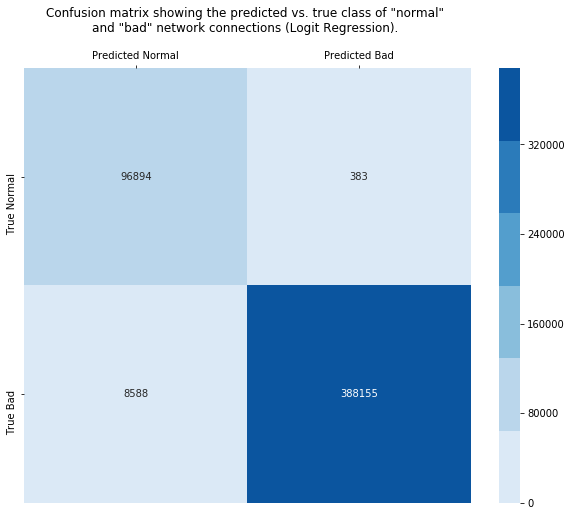

In [30]:
plot_confusion_matrix(logit_confusion_matrix, 'Logit Regression')

### Logistic Regression with Penalisation and Feature Selection

Here we consider potential enhancements to the standard logistic regression methodology applied above. In particular, we investigate the use of Principle Component Analysis (PCA) to rank and select features of the model. Further, we consider the applicability of adding a penalization term to the maximum likelihood estimation.

This investigation is included in the file [daniel-jones-logistic-regression.ipynb](./daniel-jones-logistic-regression.ipynb), and it's results are summarised in the confusion matrix below:

In [31]:
logit_penalised_confusion_matrix = numpy.array([
    [96963, 315],
    [4181, 392562],
])

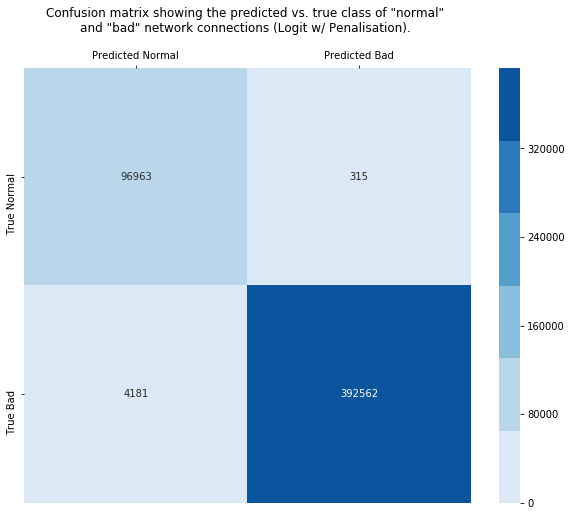

In [32]:
plot_confusion_matrix(logit_penalised_confusion_matrix, 'Logit w/ Penalisation')

### Support Vector Machine


 In this assignment, our main task was to create models that would be able to predict 'normal' or 'bad' connections with a high level of accuracy. The 'normal' column in the data had a number of different names for the red team activities, but, in essence, they were all malicious and could be classified as such. Thus, to simplify things to a certain extent, all the malicious events have been classified under a single heading - 'bad'. Thus, now the 'normal' column in kddata can be thought to contain binary data (if we consider 1 = 'bad' and 0 = 'normal'), and our problem becomes that of prediction and classification of binary data. 

The basic steps in our analysis include training our model on a training set of data, and then testing it on a new set (i.e, data which hasn't been fed into the model yet), to see how well the model manages to classify objects it hasn't encountered before. 
The model I have chosen for my part is Support Vector Machines.

### Reasoning -

By definition, Support Vector Machines are supervised learning models used for analysis of data related to classification and/or regression. An SVM Model maps the data as points in space, so that the points belonging to different categories are separated by a gap, which is maximised. New data points (i.e, the observations from the Test Data set) are then mapped into the same space and predicted to belong to a category, depending on their position relative to the gap. 
Another advantage of using SVM is that this method utilises a technique called the 'Kernel Trick', which allows us to work with high dimensional data, but without the corresponding high cost of computation. It does this by computing the inner products of the images of all pairs of data, instead of explicitly computing the co-ordinates of the data.
Since our data originally had 42 variables (including the response), this seems like a logical choice of model. 

Note - A detailed description of the mathematics behind this technique and my model is provided in the Reflection.  

The details of this model can be found in the notebook "SVM Model (Kishalay).Rmd". Please go there now.

In [33]:
svm_confusion_matrix = numpy.array([
    [28497, 25],
    [956, 316439],
])

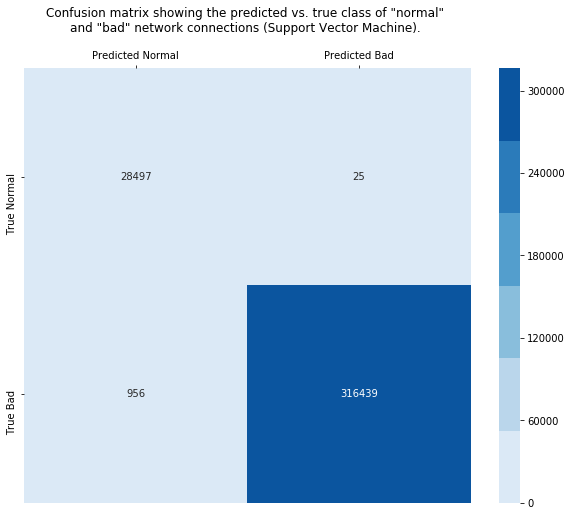

In [34]:
plot_confusion_matrix(svm_confusion_matrix, 'Support Vector Machine')

## Model Evaluation
The table below summarises the performance of each of our models:

In [35]:
pandas.DataFrame(
    [
        [sensitivity(logit_confusion_matrix)*100, false_positive_rate(logit_confusion_matrix)*100],
        [sensitivity(logit_penalised_confusion_matrix)*100, false_positive_rate(logit_penalised_confusion_matrix)*100],
        [sensitivity(svm_confusion_matrix)*100, false_positive_rate(svm_confusion_matrix)*100],
    ],
    index=['Logistic Regression', 'Logistic Regression with Penalisation', 'Support Vector Machines'],
    columns=['Sensitivity (%)', 'False Positive Rate (%)'],
)

,Sensitivity (%),False Positive Rate (%)
Logistic Regression,97.835375,0.393721
Logistic Regression with Penalisation,98.946169,0.323814
Support Vector Machines,99.698798,0.087652


All three of the models are within our compliance budget for false positives. This means that our hypothetical security team should be able to adaquately handle all security incidents. 

Adding penalisation has increased the sensitivity and reduced the false positive rate when using logistic regression. It is clear, however, that support vector machines gave us the most sensitive model overall, with the lowest false positive rate by a factor of four.

## Evaluation of Performance Metric

In order to "pick a winner" we needed to select a single metric with which to compare our models. Given the requirements of intrusion detection systems, we determined this would be hard to do. To augment our single metric, we introduced the concept of a compliance budget, and estimated the capability of a hypothetical security team. This allowed us to develop a maximum false positive rate; a threshold above which the intrusion detection system is deemed to produce an unmanageable number of false alarms.

Since the maximum false positive rate takes into account the specificity of the model, we determined that sensitivity would be a good secondary measure of model performance. 

A potential improvement to our performance metric would be to use real-world class ratios in the test data sets. That is, we would not expect 80% of traffic within "typical U.S. Air Force LAN" [2] to be malicious. A performance metric which takes into account the rarity of the "bad" class would be a better measure.

## References

[1]: rpy2, https://rpy2.bitbucket.io/.

[2]: KDD-CUP-99 Task Description, http://kdd.ics.uci.edu/databases/kddcup99/task.html.

[3]: Hettich, S. and Bay, S. D. (1999). The UCI KDD Archive [http://kdd.ics.uci.edu]. Irvine, CA: University of California, Department of Information and Computer Science.

[4]: Scikit-learn: Machine Learning in Python, Pedregosa et al., JMLR 12, pp. 2825-2830, 2011.

[5]: Confusion Matrix – Another Single Value Metric – Kappa Statistic, https://standardwisdom.com/softwarejournal/2011/12/confusion-matrix-another-single-value-metric-kappa-statistic/

[6]: Practical Statistics for Data Science, 1st ed., by Peter Bruce and Andrew Bruce (O’Reilly Media, 2017).

[7]: Beautement, Adam, M. Angela Sasse, and Mike Wonham. "The compliance budget: managing security behaviour in organisations." Proceedings of the 2008 New Security Paradigms Workshop. ACM, 2009.

[8]: What-is-logistic-regression: https://www.statisticssolutions.com/what-is-logistic-regression/

[9]: Weirich, Dirk. “Persuasive password security.” CHI Extended Abstracts (2001).

[10]: Principal Component Analysis (PCA) for Feature Selection and some of its Pitfalls, http://jotterbach.github.io/2016/03/24/Principal_Component_Analysis/

[11]: Liu, Huan, and Lei Yu. "Toward integrating feature selection algorithms for classification and clustering." IEEE Transactions on knowledge and data engineering 17.4 (2005): 491-502. https://doi.org/10.1109/TKDE.2005.66

[12]: BST 764: Applied Statistical Modelling, https://web.as.uky.edu/statistics/users/pbreheny/764-F11/notes/8-30.pdf

[13]: Penalized logistic regression with rare events: Preliminary Results, p12 http://prema.mf.uni-lj.si/files/PREMAPreliminary_Lara_AS2015_f98.pdf.

[14]: Logistic-Regression: Likelihood Ratio (or Deviance) Test, https://onlinecourses.science.psu.edu/stat501/node/374/ 

[15]: Katos, V., 2007. Network intrusion detection: Evaluating cluster, discriminant, and logit analysis. Information Sciences, 177(15), pp.3060-3073. https://doi.org/10.1016/j.ins.2007.02.034 
